In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
torch.manual_seed(1)

In [8]:
TRAIN_DATA_CONTEXT_PATH = "data/train_context.txt"
TEST_DATA_CONTEXT_PATH = "data/test_context.txt"

In [9]:
EMBEDDING_DIM = 300
LSTM_NUM_UNITS = 512

EPOCHS = 50
BATCH_SIZE = 50
BATCHES_PER_EPOCH = 50

In [10]:
def load_data(train_data_context_path, test_data_context_path):

    train_context = [line.strip() for line in open(train_data_context_path).readlines()]
    test_context = [line.strip() for line in open(test_data_context_path).readlines()]
    
    return train_context, test_context

def indexing(_train_context, _test_context):

    train_context = []

    poi2id = {"<PAD>":0}
    id2poi = ["<PAD>"]

    for line in _train_context:
        tokens = line.split("\t")
        for poi in tokens:
            if poi not in poi2id:
                poi2id[poi] = len(poi2id)
                id2poi.append(poi)
        train_context.append([poi2id[poi] for poi in tokens])
        
    test_context = []
    
    for line in _test_context:
        tokens = line.split("\t")
        test_context.append([poi2id.get(poi, 0) for poi in tokens])

    return poi2id, id2poi, train_context, test_context

def as_matrix(sequences, max_len=None):
    max_len = max_len or max(map(len, sequences))
    matrix = np.zeros((len(sequences), max_len), dtype=np.int32)
    for i, seq in enumerate(sequences):
        matrix[i, :len(seq)] = seq
    return matrix

def generate_batches(context, batch_size):
    context_ix = as_matrix(np.random.choice(train_context, batch_size, replace=False))
    batch_context = []
    for ix in context_ix:
        batch_context.append([EMBEDDING_MATRIX[i] for i in ix])
    return batch_context

In [11]:
class LSTMLoop(nn.Module):
    def __init__(self, poi_num, embedding_dim, lstm_num_units, embedding_matrix):
        super().__init__()
        self.poi_num = poi_num
        self.embedding_dim = embedding_dim
        self.lstm_num_units = lstm_num_units
        self.weight = Variable(torch.FloatTensor(embedding_matrix))
        
        self.emb = nn.Embedding(self.poi_num, self.embedding_dim, _weight=self.weight)
        self.lstm = nn.LSTM(self.embedding_dim, self.lstm_num_units, batch_first=True)
        self.logits = nn.Linear(self.lstm_num_units, self.poi_num)
        
        self.emb.weight.requires_grad = False
        
    def forward(self, context):
        lstm_inp = self.emb(context)
        lstm_out, _ = self.lstm(lstm_inp)
        logits = self.logits(lstm_out)
        return logits

In [12]:
def compute_loss(network, context):
    
    context_inp = context[:, :-1].contiguous()
    context_next = context[:, 1:].contiguous()
    
    logits_for_next = network.forward(context_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    logp_for_next = F.log_softmax(logits_for_next, dim=-1)
    loss = F.nll_loss(logp_for_next.contiguous().view(-1, poi_num), 
                      context_next.view(-1),
                      ignore_index=0)
    
    return loss

In [42]:
print("Data Loading..")
train_context, test_context = load_data(TRAIN_DATA_CONTEXT_PATH, TEST_DATA_CONTEXT_PATH)

print("Data Indexing..")
poi2id, id2poi, train_context, test_context = indexing(train_context, test_context)
poi_num = len(poi2id)
print('Number of POIs: {}'.format(len(poi2id)-1))

Data Loading..
Data Indexing..
Number of POIs: 2861


In [26]:
id2poi_df = pd.DataFrame(id2poi)
id2poi_df.to_csv('id2poi.csv', index=False)

In [39]:
_id2poi = []
for i, val in enumerate(id2poi):
    _id2poi.append((i, val))
pd.DataFrame(_id2poi).to_csv('id2poi.csv', index=False)

In [37]:
poi2id_df = pd.DataFrame({0: poi2id.values(), 1:poi2id.keys()},)
poi2id_df.to_csv('poi2id.csv', index=False)

In [41]:
len(poi2id)

2862

In [44]:
with open('../POI-Recommender-based-on-Instagram-Profile-master/data/poi2id.json') as f:
    a = json.load(f)

In [2]:
df = pd.read_csv('../POI-Recommender-based-on-Instagram-Profile-master/data/pics.csv')

In [53]:
with open('a', 'w') as f:
    json.dump(['Stockholms län, Sweden'], f)

In [7]:
set(df.location)

{nan,
 "Cherkas'ka oblast, Ukraine",
 'กระบี่, Thailand',
 'Corfu, Greece',
 'Ben Tre, Vietnam',
 'Zagrebačka županija, Croatia',
 'Fukui, Japan',
 '沖縄県, Japan',
 'Fajardo, Puerto Rico',
 'Ulsan, South Korea',
 'Saulkrastu pilsēta, Latvia',
 'Ocho Rios, Jamaica',
 'Espírito Santo, Brazil',
 'Calabarzon, Philippines',
 'Karabük, Turkey',
 'Jihomoravský kraj, Czechia',
 'Vedersø, Denmark',
 'Ravne na Koroškem, Slovenia',
 'Altay Prefecture, China',
 'Yalova, Turkey',
 'Valais, Switzerland',
 'Southern Aegean, Greece',
 'State of Amazonas, Brazil',
 'Rivière Noire District, Mauritius',
 'Capesterre-de-Marie-Galante, Guadeloupe',
 'Rakhine, Myanmar (Burma)',
 'Kep Province, Cambodia',
 'Kedah, Malaysia',
 'Stann Creek District, Belize',
 'Beijing Shi, China',
 'Gazimağusa, Cyprus',
 'Saint-Pierre, Martinique',
 'Qakh, Azerbaijan',
 'Saint Pierre, ',
 'Quảng Nam, Vietnam',
 'Seltjarnarnes, Iceland',
 'Guatemala, Guatemala',
 'Mommark, Denmark',
 'دبي, United Arab Emirates',
 'Brașov County,

In [43]:
with open('poi2id.json', 'w', encoding='utf-8') as f:
    json.dump(poi2id, f)
with open('id2poi.json', 'w', encoding='utf-8') as f:
    json.dump(id2poi, f)

### Train

In [163]:
def train_lstm(name):
    EMBEDDING_MATRIX = np.loadtxt('lstm_weights/{}.txt'.format(name))
    network = LSTMLoop(poi_num, EMBEDDING_DIM, LSTM_NUM_UNITS, EMBEDDING_MATRIX)
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, network.parameters()))
    history = []
    print('Training')
    for epoch in range(EPOCHS):

        network.train(True)
        train_loss=0
        for _ in range(BATCHES_PER_EPOCH):

            batch_context = as_matrix(np.random.choice(train_context, BATCH_SIZE, replace=False))
            batch_context = Variable(torch.LongTensor(batch_context))
            loss_t = compute_loss(network, batch_context)

            opt.zero_grad()
            loss_t.backward()
            opt.step()

            train_loss += loss_t.detach().numpy()

        train_loss /= BATCHES_PER_EPOCH

        print('\nEpoch: {}, train loss: {}'.format(epoch + 1, train_loss))

    PATH = 'lstm_weights/{}.pt'.format(name)
    torch.save(network.state_dict(), PATH)

    auc_roc = auc_roc_score(network, test_context)
    recall_1 = recall_k(network, test_context, 1)
    recall_5 = recall_k(network, test_context, 5)
    recall_10 = recall_k(network, test_context, 10)
    print('{}: auc {}, r1 {}, r5 {}, r10 {}'.format(name, auc_roc, recall_1, recall_5, recall_10))
    metrics_dict = {}
    with open('metrics/metrics_dict.json', 'r') as f:
        metrics_dict = json.load(f)
    metrics = {
        'auc_roc': auc_roc,
        'recall_1': recall_1,
        'recall_5': recall_5,
        'recall_10': recall_10
    }
    metrics_dict[name] = metrics
    with open('metrics/metrics_dict.json', 'w') as f:
        json.dump(metrics_dict, f)

In [209]:
name = 'a_0.4_b_0.4_new'
train_lstm(name)

Training

Epoch: 1, train loss: 6.405007619857788

Epoch: 2, train loss: 5.484228982925415

Epoch: 3, train loss: 4.861488456726074

Epoch: 4, train loss: 4.40307044506073

Epoch: 5, train loss: 4.001579456329345

Epoch: 6, train loss: 3.8240658712387083

Epoch: 7, train loss: 3.65837863445282

Epoch: 8, train loss: 3.5083879137039187

Epoch: 9, train loss: 3.3690894508361815

Epoch: 10, train loss: 3.261073851585388

Epoch: 11, train loss: 3.209342555999756

Epoch: 12, train loss: 3.104484648704529

Epoch: 13, train loss: 3.0895191192626954

Epoch: 14, train loss: 2.9924545431137086

Epoch: 15, train loss: 2.9394746160507204

Epoch: 16, train loss: 2.8551569509506227

Epoch: 17, train loss: 2.8481203365325927

Epoch: 18, train loss: 2.770122184753418

Epoch: 19, train loss: 2.75560498714447

Epoch: 20, train loss: 2.6809140396118165

Epoch: 21, train loss: 2.649260959625244

Epoch: 22, train loss: 2.633498830795288

Epoch: 23, train loss: 2.5685103607177733

Epoch: 24, train loss: 2.5

  0%|▎                                                                             | 34/10027 [00:00<00:29, 333.52it/s]


Epoch: 50, train loss: 1.5953874397277832


100%|███████████████████████████████████████████████████████████████████████████| 10027/10027 [00:20<00:00, 496.70it/s]

a_0.4_b_0.8_new: auc 0.9382732897904816, r1 0.2807419966091553, r5 0.4879824473920415, r10 0.5637777999401615


In [118]:
name = 'a_0.4_b_1.2'
EMBEDDING_MATRIX = np.loadtxt('lstm_weights/{}.txt'.format(name))

In [119]:
network = LSTMLoop(poi_num, EMBEDDING_DIM, LSTM_NUM_UNITS, EMBEDDING_MATRIX)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, network.parameters()))
history = []

In [120]:
for epoch in range(EPOCHS):
    
    network.train(True)
    train_loss=0
    for _ in tqdm(range(BATCHES_PER_EPOCH)):
        
        batch_context = as_matrix(np.random.choice(train_context, BATCH_SIZE, replace=False))
        batch_context = Variable(torch.LongTensor(batch_context))
        loss_t = compute_loss(network, batch_context)
        
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.detach().numpy()
        
    train_loss /= BATCHES_PER_EPOCH
    
    print('\nEpoch: {}, train loss: {}'.format(epoch + 1, train_loss))

print("Finished!")

  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.67it/s]


Epoch: 1, train loss: 6.83678936958313


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  8.00it/s]


Epoch: 2, train loss: 5.953783292770385


  2%|█▋                                                                                 | 1/50 [00:00<00:05,  8.27it/s]


Epoch: 3, train loss: 5.469306602478027


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.62it/s]


Epoch: 4, train loss: 4.8895785427093506


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.94it/s]


Epoch: 5, train loss: 4.615852427482605


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.20it/s]


Epoch: 6, train loss: 4.357277755737305


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.70it/s]


Epoch: 7, train loss: 4.222148742675781


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.85it/s]


Epoch: 8, train loss: 4.047121248245239


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.81it/s]


Epoch: 9, train loss: 3.913764443397522


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.63it/s]


Epoch: 10, train loss: 3.7702778673171995


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.7423292922973634


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.37it/s]


Epoch: 12, train loss: 3.593791356086731


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.20it/s]


Epoch: 13, train loss: 3.5436779069900513


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.89it/s]


Epoch: 14, train loss: 3.4477629375457766


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.20it/s]


Epoch: 15, train loss: 3.283995342254639


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.58it/s]


Epoch: 16, train loss: 3.398623046875


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  6.10it/s]


Epoch: 17, train loss: 3.1975084829330442


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.21it/s]


Epoch: 18, train loss: 3.262019567489624


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.29it/s]


Epoch: 19, train loss: 3.175481610298157


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.47it/s]


Epoch: 20, train loss: 3.1348003005981444


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  5.08it/s]


Epoch: 21, train loss: 3.0834314966201783


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.41it/s]


Epoch: 22, train loss: 3.0398077630996703


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 2.9893260908126833


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  5.03it/s]


Epoch: 24, train loss: 2.9462453079223634


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.95it/s]


Epoch: 25, train loss: 2.9064724397659303


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.91it/s]


Epoch: 26, train loss: 2.902254595756531


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.48it/s]


Epoch: 27, train loss: 2.84036997795105


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 2.823073048591614


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.71it/s]


Epoch: 29, train loss: 2.7626512241363526


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 2.736831374168396


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.18it/s]


Epoch: 31, train loss: 2.7612360763549804


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 2.7028274393081664


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.41it/s]


Epoch: 33, train loss: 2.652384920120239


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 2.616148190498352


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.72it/s]


Epoch: 35, train loss: 2.628565721511841


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.18it/s]


Epoch: 36, train loss: 2.6149716997146606


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.41it/s]


Epoch: 37, train loss: 2.504119381904602


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.46it/s]


Epoch: 38, train loss: 2.514626123905182


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.82it/s]


Epoch: 39, train loss: 2.444736247062683


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.41it/s]


Epoch: 40, train loss: 2.4473953151702883


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.47it/s]


Epoch: 41, train loss: 2.387512040138245


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.52it/s]


Epoch: 42, train loss: 2.380930495262146


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  6.03it/s]


Epoch: 43, train loss: 2.3369769620895386


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.15it/s]


Epoch: 44, train loss: 2.2998995685577395


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.52it/s]


Epoch: 45, train loss: 2.2875636172294618


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.50it/s]


Epoch: 46, train loss: 2.240254530906677


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  6.03it/s]


Epoch: 47, train loss: 2.182694492340088


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.68it/s]


Epoch: 48, train loss: 2.1639738726615905


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.30it/s]


Epoch: 49, train loss: 2.141031150817871


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.12it/s]


Epoch: 50, train loss: 2.1580838537216187
Finished!


2.53

In [123]:
PATH = 'lstm_weights/{}.pt'.format(name)
torch.save(network.state_dict(), PATH)

In [160]:
def predict_word(network, seq, k=1):
    network.train(False)
    previous_word = Variable(torch.LongTensor(as_matrix([seq])))
    next_word_logits = network.forward(previous_word)[0, -1]
    next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
    next_word_ix = np.argsort(next_word_probs)[::-1]
    if k == 'all':
        return next_word_ix
    return next_word_ix[:k]

In [161]:
def recall_k(network, context, k=1):
    corrects = 0
    for seq in tqdm(context):
        X = seq[:-1]
        y_true = seq[-1]
        y_pred_k = predict_word(network, X, k)
        for y_pred in y_pred_k:
            if y_pred == y_true:
                corrects += 1
                break
    return corrects/len(context)

In [162]:
def auc_roc_score(network, context):
    auc = 0
    for seq in tqdm(context):
        X = seq[:-1]
        y_true = seq[-1]
        rank = predict_word(network, X, 'all')
        rank_true = np.where(rank == y_true)[0][0]
        #y_false = set(range(1, poi_num)) - set(seq)
        s = poi_num - len(seq) - 1
        for i in rank[:rank_true]:
            if i not in seq:
                s -= 1
        auc += s/(poi_num - len(seq) - 1)
    return auc/len(context)

In [169]:
auc_roc = auc_roc_score(network, test_context)
auc_roc

100%|███████████████████████████████████████████████████████████████████████████| 12894/12894 [00:32<00:00, 399.90it/s]


0.9493562500759433

0.94

In [170]:
recall_1 = recall_k(network, test_context, 1)
recall_1

100%|███████████████████████████████████████████████████████████████████████████| 12894/12894 [00:36<00:00, 353.62it/s]


0.2756320769350085

0.27

In [171]:
recall_5 = recall_k(network, test_context, 5)
recall_5

100%|███████████████████████████████████████████████████████████████████████████| 12894/12894 [00:36<00:00, 357.82it/s]


0.46905537459283386

0.47

In [172]:
recall_10 = recall_k(network, test_context, 10)
recall_10

100%|███████████████████████████████████████████████████████████████████████████| 12894/12894 [00:33<00:00, 384.68it/s]


0.5380797270048084

0.53

In [191]:
metrics_dict = {}
with open('metrics/metrics_dict.json', 'r') as f:
    metrics_dict = json.load(f)

In [132]:
metrics = {
    'auc_roc': auc_roc,
    'recall_1': recall_1,
    'recall_5': recall_5,
    'recall_10': recall_10
}
metrics_dict[name] = metrics

In [133]:
with open('metrics/metrics_dict.json', 'w') as f:
    json.dump(metrics_dict, f)

### Plot

In [211]:
with open('metrics/metrics_dict.json', 'r') as f:
    metrics_dict = json.load(f)

In [230]:
xx, yy1, yy2, yy3, yy4 = [], [], [], [], []
for i in np.arange(0.0, 1.2, 0.2):
    n = round(i, 1)
    name = 'a_0.4_b_{}_new'.format(n)
    metrics = metrics_dict[name]
    yy1.append(metrics['auc_roc'])
    yy2.append(metrics['recall_1'])
    yy3.append(metrics['recall_5'])
    yy4.append(metrics['recall_10'])
    xx.append(n)

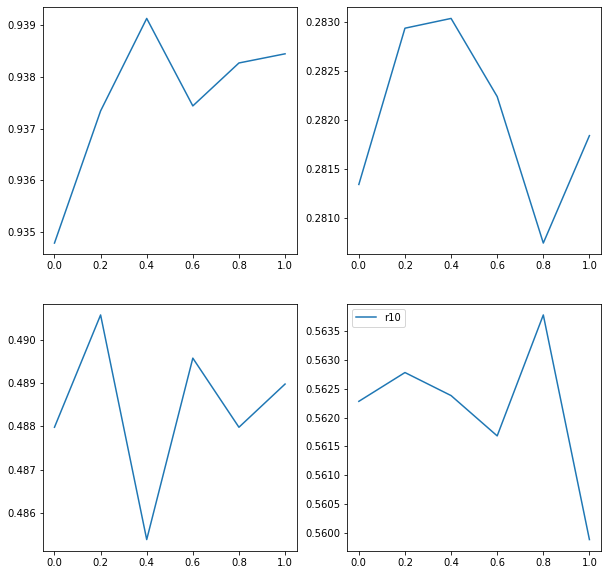

In [244]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(xx, yy1, label='auc')
plt.subplot(2, 2, 2)
plt.plot(xx, yy2, label='r1')
plt.subplot(2, 2, 3)
plt.plot(xx, yy3, label='r5')
plt.subplot(2, 2, 4)
plt.plot(xx, yy4, label='r10')
plt.legend()
plt.show()